# Neural Network (nn)

[Edward Lu](https://github.com/edwardlu71/notebooks)

### Neural Network with One Hidden Layer

- input layer
- linear layer
- activation (ReLu)
- full connection layer (linear)

### About input

input flattens data into 1 dimension array. i.e.

In [7]:
import numpy as np

# define a 3x3 random pixel dataset
pic = np.random.random((3,3))
print(pic.shape)
print(pic)

(3, 3)
[[0.52291537 0.15313264 0.42554073]
 [0.52667107 0.42158546 0.18859749]
 [0.74916014 0.71248759 0.84333359]]


In [2]:
pic.T

array([[0.33439957, 0.17790202, 0.41344427],
       [0.31390169, 0.9838339 , 0.76259498],
       [0.96190486, 0.17268697, 0.27361627]])

In [8]:
flatten_pic = pic.flatten()
print(flatten_pic.shape)
print(flatten_pic)

(9,)
[0.52291537 0.15313264 0.42554073 0.52667107 0.42158546 0.18859749
 0.74916014 0.71248759 0.84333359]


In [3]:
vertical = flatten_pic.reshape(9,1)
print(vertical)

[[0.20310875]
 [0.45836374]
 [0.57879924]
 [0.3970125 ]
 [0.97272879]
 [0.06992504]
 [0.52767736]
 [0.5244745 ]
 [0.73478836]]


In [5]:
flatten_pic @ vertical # dot

array([2.9923705])

## Standard example of handwritten digits recognition (MNIST)

[example](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from time import time, sleep
import os
from random import randint

In [2]:
# Hyper-parameters
#
# 28x28 size pixel of an image for input
input_size = 784
# size of middle layers
hidden_size = 500
# output size, characters of 0-9
num_classes = 10

# training parameters
num_epochs = 3
batch_size = 100
learning_rate = 0.001

In [3]:
# data source
#
# load the data from MNIST dataset to local disk
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
# Data loader len(train_loader) = 600, so total 600x100 images
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
train_dataset.data.size(), test_dataset.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
data_iter = iter(test_loader)

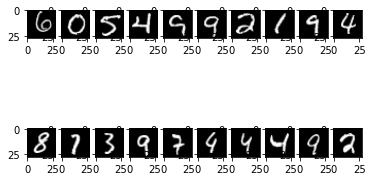

[6 0 5 4 9 9 2 1 9 4 8 7 3 9 7 4 4 4 9 2]


In [10]:
# example_data.size() = torch.Size([100, 1, 28, 28]). It's 4 dim data of 100 samples, 1 color, 28x28 pixels
# example_data stores 100 samples of image data of 0-9 characters; example_targets stores the 100 actual characters of the images
images, labels = data_iter.next()

# debug: show the first 6 images
for i in range(20):
    plt.subplot(2, 10, i+1) # 2 x 5 subplots
    plt.imshow(images[i][0], cmap='gray')
plt.show()

print(labels.numpy()[:20])


## Define the model: input layer + activation + output layer

In [11]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        # activation
        self.relu = nn.ReLU()
        # full connection layer
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out1 = self.l2(out)
        # no activation and no softmax at the end
        return out1, out

In [12]:
model = NeuralNet(input_size, hidden_size, num_classes)
print(model)

NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)


### Training

- trained model is saved in file ./mnist

In [14]:
torch.manual_seed(int(time()))
device = torch.device('cpu')

if os.path.isfile("./mnist"):
    model = torch.load("./mnist", map_location=lambda storage, loc: storage)
    model.eval()
else:
    model = NeuralNet(input_size, hidden_size, num_classes).to(device)

    # define Loss function and choose optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # loop 600 times, each time with 100 images + labels in a batch.
            #
            # images origin shape: [100, 1, 28, 28]
            # resized: [100, 784] = images is a 100 size batch each with 784 inputs for one image
            # input is flattened to one dimension arry of size 28*28 = 784, with 100 sample in one batch
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            # Forward pass
            #
            # outputs with shape [100, 10] for the result of 100 size batch, each with output of possibility on 0-9 charactors
            outputs, last_layer = model(images)
            # how likely the predicted in output matches real characters in labels. loss is only one figure as result of a 100 size batch training
            loss = criterion(outputs, labels)

            # Backward and optimize
            #
            # cleanup the history first
            optimizer.zero_grad()
            # dLoss/dWeights
            loss.backward()
            # adjust weights from dLoss/dWeights
            optimizer.step()

            if i % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}')

    torch.save(model, "mnist")

Epoch [1/3], Step [0/600], Loss: 2.3088
Epoch [1/3], Step [100/600], Loss: 0.4088
Epoch [1/3], Step [200/600], Loss: 0.1779
Epoch [1/3], Step [300/600], Loss: 0.2648
Epoch [1/3], Step [400/600], Loss: 0.3057
Epoch [1/3], Step [500/600], Loss: 0.2394
Epoch [2/3], Step [0/600], Loss: 0.1784
Epoch [2/3], Step [100/600], Loss: 0.2349
Epoch [2/3], Step [200/600], Loss: 0.1229
Epoch [2/3], Step [300/600], Loss: 0.1493
Epoch [2/3], Step [400/600], Loss: 0.0912
Epoch [2/3], Step [500/600], Loss: 0.0779
Epoch [3/3], Step [0/600], Loss: 0.0362
Epoch [3/3], Step [100/600], Loss: 0.0769
Epoch [3/3], Step [200/600], Loss: 0.0460
Epoch [3/3], Step [300/600], Loss: 0.0695
Epoch [3/3], Step [400/600], Loss: 0.1396
Epoch [3/3], Step [500/600], Loss: 0.1012


In [15]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, last_layer = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.55 %


label=2 predicted 2


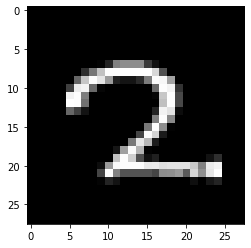

In [20]:
with torch.no_grad():
    # region debug
    data_iter = iter(test_loader)
    images, labels = data_iter.next()

    images = images.reshape(-1, 28 * 28).to(device)
    labels = labels.to(device)
    outputs, last_layer = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)

    images = images.reshape(-1, 28, 28).to(device)
    labels_np = labels.numpy()
    predicted_np = predicted.numpy()

    k = randint(0, 100)
    print(f"label={labels_np[k]} predicted {predicted_np[k]}")
    plt.imshow(images[k], cmap='gray')
    plt.show()
    # endregion

In [18]:
print(predicted)
print(labels)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])


## How does computer classify the pictures

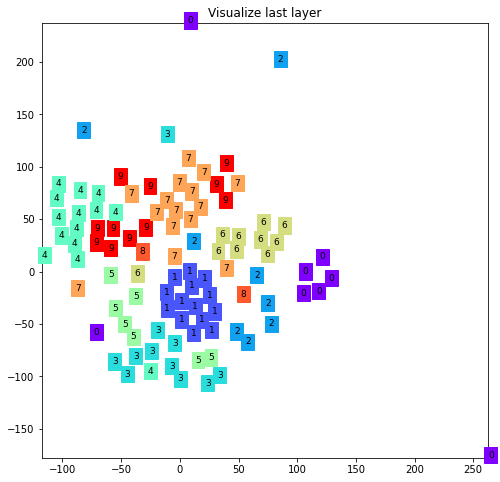

In [22]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])   # last_layer from the model output
labels1 = labels.numpy()[:plot_only]                                         # what them represent

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plot_with_labels(low_dim_embs, labels1)
plt.ioff()